In [1]:
import warnings
warnings.filterwarnings("ignore")

在本章中我们会讨论一下特别著名的集成方法，包括 **bagging, boosting, stacking**，和其他一些算法。我们也会讨论随机森林。

## 投票分类
假设你已经训练了一些分类器，每一个都有 80% 的准确率。你可能有了一个逻辑回归、或一个 SVM、或一个随机森林，或者一个 KNN分类器，一个非常简单的创建一个更好的分类器的方法就是去整合每一个分类器的预测然后经过投票预测分类。这种分类器叫做硬投票分类器。

然而每一个分类器都在同一个数据集上训练，导致其很可能会发生这样的错误。他们可能会犯同一种错误，所以也会有很多票投给了错误类别导致集成的准确率下降。

如果使每一个分类器都独立自主的分类，那么集成模型会工作的很好。得到多样的分类器的方法之一就是用完全不同的算法，这会使它们会做出不同种类的错误，但会提高集成的正确率。
接下来的代码创建和训练了在 sklearn 中的投票分类器。这个分类器由三个不同的分类器组成

In [20]:
from sklearn.datasets import load_iris
iris_data = load_iris()
X,y = iris_data.data, iris_data.target

In [21]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import VotingClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=42)
log_clf = LogisticRegression(multi_class="multinomial") 
rnd_clf = RandomForestClassifier() 
svm_clf = SVC()
polynomial_svm_clf = Pipeline((
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge"))
    ))
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf),
                                         ('pc',polynomial_svm_clf,)],voting='hard') 
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(multi_class='multinomial')),
                             ('rf', RandomForestClassifier()), ('svc', SVC()),
                             ('pc',
                              Pipeline(steps=(('poly_features',
                                               PolynomialFeatures(degree=3)),
                                              ('scaler', StandardScaler()),
                                              ('svm_clf',
                                               LinearSVC(C=10,
                                                         loss='hinge')))))])

In [22]:
from sklearn.metrics import accuracy_score 
for clf in (log_clf, rnd_clf, polynomial_svm_clf, svm_clf, voting_clf): 
    clf.fit(X_train, y_train) 
    y_pred = clf.predict(X_test) 
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 1.0
RandomForestClassifier 0.98
Pipeline 0.98
SVC 1.0
VotingClassifier 0.98


如果所有的分类器都能够预测类别的概率（例如他们有一个predict_proba()方法），那么你就可以让 sklearn 以最高的类概率来预测这个类，平均在所有的分类器上。这种方式叫做软投票。他经常比硬投票表现的更好，因为它给予高自信的投票更大的权重。你可以通过把voting="hard"设置为voting="soft"来保证分类器可以预测类别概率。然而这不是 SVC 类的分类器默认的选项，所以你需要把它的probability hyperparameter设置为True（这会使 SVC 使用交叉验证去预测类别概率，其降低了训练速度，但会添加predict_proba()方法）。如果你修改了之前的代码去使用软投票，你会发现投票分类器正确率高达 91%

## Bagging 和 Pasting
就像之前讲到的，可以通过使用不同的训练算法去得到一些不同的分类器。另一种方法就是对每一个分类器都使用相同的训练算法，但是在不同的训练集上去训练它们。有放回采样被称为装袋（Bagging，是 bootstrap aggregating 的缩写）。无放回采样称为粘贴（pasting）。

换句话说，Bagging 和 Pasting 都允许在多个分类器上对训练集进行多次采样，但只有 Bagging 允许对同一种分类器上对训练集进行进行多次采样。采样和训练过程如图7-4所示。

当所有的分类器被训练后，集成可以通过对所有分类器结果的简单聚合来对新的实例进行预测。聚合函数通常对分类是统计模式（例如硬投票分类器）或者对回归是平均。每一个单独的分类器在如果在原始训练集上都是高偏差，但是聚合降低了偏差和方差。通常情况下，集成的结果是有一个相似的偏差，但是对比与在原始训练集上的单一分类器来讲有更小的方差。

**在 sklearn 中的 Bagging 和 Pasting**<br>
sklearn 为 Bagging 和 Pasting 提供了一个简单的API：BaggingClassifier类（或者对于回归可以是BaggingRegressor。接下来的代码训练了一个 500 个决策树分类器的集成，每一个都是在数据集上有放回采样 100 个训练实例下进行训练（这是 Bagging 的例子，如果你想尝试 Pasting，就设置bootstrap=False）。n_jobs参数告诉 sklearn 用于训练和预测所需要 CPU 核的数量。（-1 代表着 sklearn 会使用所有空闲核）：

In [23]:
from sklearn.ensemble import BaggingClassifier 
from sklearn.tree import DecisionTreeClassifier
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1) 
bag_clf.fit(X_train, y_train)              
y_pred = bag_clf.predict(X_test)                          

笔记<br>
如果基分类器可以预测类别概率（例如它拥有predict_proba()方法），那么BaggingClassifier会自动的运行软投票，这是决策树分类器的情况。

**Out-of-Bag 评价**<br>

对于 Bagging 来说，一些实例可能被一些分类器重复采样，但其他的有可能不会被采样。BaggingClassifier默认采样。BaggingClassifier默认是有放回的采样m个实例 （bootstrap=True），其中m是训练集的大小，这意味着平均下来只有63%的训练实例被每个分类器采样，剩下的37%个没有被采样的训练实例就叫做 Out-of-Bag 实例。注意对于每一个的分类器它们的 37% 不是相同的。

因为在训练中分类器从来没有看到过 oob 实例，所以它可以在这些实例上进行评估，而不需要单独的验证集或交叉验证。你可以拿出每一个分类器的 oob 来评估集成本身。

在 sklearn 中，你可以在训练后需要创建一个BaggingClassifier时设置oob_score=True来自动评估。接下来的代码展示了这个操作。评估结果通过变量oob_score_来显示：

In [24]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train) 
bag_clf.oob_score_ 

0.94

In [25]:
from sklearn.metrics import accuracy_score 
y_pred = bag_clf.predict(X_test) 
accuracy_score(y_test, y_pred) 

0.98

对于每个训练实例 oob 决策函数也可通过oob_decision_function_变量来展示。在这种情况下（当基决策器有predict_proba()时）决策函数会对每个训练实例返回类别概率。例如，oob 评估预测第二个训练实例有 60.6% 的概率属于正类（39.4% 属于负类):

In [26]:
bag_clf.oob_decision_function_[:5]

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

## 随机贴片与随机子空间
BaggingClassifier也支持采样特征。它被两个超参数max_features和bootstrap_features控制。他们的工作方式和max_samples和bootstrap一样，但这是对于特征采样而不是实例采样。因此，每一个分类器都会被在随机的输入特征内进行训练。

当你在处理高维度输入下（例如图片）此方法尤其有效。对训练实例和特征的采样被叫做随机贴片。保留了所有的训练实例（例如bootstrap=False和max_samples=1.0），但是对特征采样（bootstrap_features=True并且/或者max_features小于 1.0）叫做随机子空间。

采样特征导致更多的预测多样性，用高偏差换低方差。

## 随机森林
正如我们所讨论的，随机森林是决策树的一种集成，通常是通过 bagging 方法（有时是 pasting 方法）进行训练，通常用max_samples设置为训练集的大小。建立一个BaggingClassifier，然后把它放入 DecisionTreeClassifier 。或者，你可以使用更方便的也是对决策树优化过的RandomForestClassifier（对于回归是RandomForestRegressor）。接下来的代码训练了带有 500 个树（每个被限制为 16 叶子结点）的决策森林，使用所有空闲的 CPU 核：


In [27]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1) 
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
y_pred_rf

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0,
       0, 1, 1, 2, 1, 2])

除了一些例外，RandomForestClassifier使用DecisionTreeClassifier的所有超参数（决定树怎么生长），把BaggingClassifier的超参数加起来来控制集成本身。

随机森林算法在树生长时引入了额外的随机；与在节点分裂时需要找到最好分裂特征相反（详见第六章），它在一个随机的特征集中找最好的特征。它导致了树的差异性，并且再一次用高偏差换低方差，总的来说是一个更好的模型。以下是BaggingClassifier，大致相当于之前的randomforestclassifier：

In [28]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

## 极端随机树
当你在随机森林上生长树时，在每个结点分裂时只考虑随机特征集上的特征（正如之前讨论过的一样）。相比于找到更好的特征我们可以通过使用对特征使用随机阈值使树更加随机（像规则决策树一样）。

这种极端随机的树被简称为 Extremely Randomized Trees（极端随机树），或者更简单的称为 Extra-Tree。再一次用高偏差换低方差。它还使得 Extra-Tree 比规则的随机森林更快地训练，因为在每个节点上找到每个特征的最佳阈值是生长树最耗时的任务之一。

你可以使用 sklearn 的ExtraTreesClassifier来创建一个 Extra-Tree 分类器。他的 API 跟RandomForestClassifier是相同的，相似的， ExtraTreesRegressor 跟RandomForestRegressor也是相同的 API。

我们很难去分辨ExtraTreesClassifier和RandomForestClassifier到底哪个更好。通常情况下是通过交叉验证来比较它们（使用网格搜索调整超参数）。

In [11]:
from sklearn.ensemble import ExtraTreesClassifier
X,y = iris_data.data, iris_data.target
clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf.fit(X, y)
ExtraTreesClassifier(random_state=0)
clf.predict(X_test)

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0,
       0, 1, 2, 2, 1, 2])

## 孤立森林

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

# 生成训练数据
X = 0.3 * rng.randn(100, 2)
X_train = np.r_[X + 1, X - 3, X - 5, X + 6]

# 生成正常数据
X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 1, X - 3, X - 5, X + 6]

# 生成异常数据
X_outliers = rng.uniform(low=-8, high=8, size=(20, 2))

训练集:[-1  1]
测试集: [ 1 -1]
异常:[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


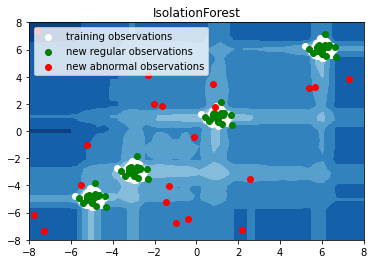

In [13]:
# 使用模型
clf = IsolationForest(max_samples=100*2, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
print('训练集:{}'.format(y_pred_train[3:5]))
y_pred_test = clf.predict(X_test)
print('测试集: {}'.format(y_pred_test[3:5]))
y_pred_outliers = clf.predict(X_outliers)
print('异常:{}'.format(y_pred_outliers))
 
# 作图
xx, yy = np.meshgrid(np.linspace(-8, 8, 50), np.linspace(-8, 8, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red')
plt.axis('tight')
plt.xlim((-8, 8))
plt.ylim((-8, 8))
plt.legend([b1, b2, c],
           ["training observations",
            "new regular observations", "new abnormal observations"],
           loc="upper left")
plt.show()

## 特征重要度
最后，如果你观察一个单一决策树，重要的特征会出现在更靠近根部的位置，而不重要的特征会经常出现在靠近叶子的位置。因此我们可以通过计算一个特征在森林的全部树中出现的平均深度来预测特征的重要性。sklearn 在训练后会自动计算每个特征的重要度。你可以通过feature_importances_变量来查看结果。例如如下代码在 iris 数据集（第四章介绍）上训练了一个RandomForestClassifier模型，然后输出了每个特征的重要性。看来，最重要的特征是花瓣长度（44%）和宽度（42%），而萼片长度和宽度相对比较是不重要的（分别为 11% 和 2%）：

In [29]:
from sklearn.datasets import load_iris 
iris = load_iris() 
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1) 
rnd_clf.fit(iris["data"], iris["target"]) 
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_): 
    print(name, score) 

sepal length (cm) 0.09634970621161472
sepal width (cm) 0.021657270574506806
petal length (cm) 0.42566547524150755
petal width (cm) 0.45632754797237085


## 提升
提升（Boosting，最初称为假设增强）指的是可以将几个弱学习者组合成强学习者的集成方法。对于大多数的提升方法的思想就是按顺序去训练分类器，每一个都要尝试修正前面的分类。现如今已经有很多的提升方法了，但最著名的就是 Adaboost（适应性提升，是 Adaptive Boosting 的简称） 和 Gradient Boosting（梯度提升）。让我们先从 Adaboost 说起。

## Adaboost
使一个新的分类器去修正之前分类结果的方法就是对之前分类结果不对的训练实例多加关注。这导致新的预测因子越来越多地聚焦于这种情况。这是 Adaboost 使用的技术。

举个例子，去构建一个 Adaboost 分类器，第一个基分类器（例如一个决策树）被训练然后在训练集上做预测，在误分类训练实例上的权重就增加了。第二个分类机使用更新过的权重然后再一次训练，权重更新，以此类推<br>
警告<br>
序列学习技术的一个重要的缺点就是：它不能被并行化（只能按步骤），因为每个分类器只能在之前的分类器已经被训练和评价后再进行训练。因此，它不像Bagging和Pasting一样。

sklearn 通常使用 Adaboost 的多分类版本 SAMME（这就代表了 分段加建模使用多类指数损失函数）。如果只有两类别，那么 SAMME 是与 Adaboost 相同的。如果分类器可以预测类别概率（例如如果它们有predict_proba()），如果 sklearn 可以使用 SAMME 叫做SAMME.R的变量（R 代表“REAL”），这种依赖于类别概率的通常比依赖于分类器的更好。

接下来的代码训练了使用 sklearn 的AdaBoostClassifier基于 200 个决策树桩的Adaboost 分类器（正如你说期待的，对于回归也有AdaBoostRegressor）。一个决策树桩是max_depth=1的决策树-换句话说，是一个单一的决策节点加上两个叶子结点。这就是AdaBoostClassifier的默认基分类器：

In [30]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200,algorithm="SAMME.R", learning_rate=0.5) 
ada_clf.fit(X_train, y_train)
ada_clf.predict(X_test)

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 1,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0,
       0, 1, 1, 2, 1, 2])

如果你的 Adaboost 集成过拟合了训练集，你可以尝试减少基分类器的数量或者对基分类器使用更强的正则化。

## 梯度提升
另一个非常著名的提升算法是梯度提升。与 Adaboost 一样，梯度提升也是通过向集成中逐步增加分类器运行的，每一个分类器都修正之前的分类结果。然而，它并不像 Adaboost 那样每一次迭代都更改实例的权重，这个方法是去使用新的分类器去拟合前面分类器预测的残差 。

让我们通过一个使用决策树当做基分类器的简单的回归例子（回归当然也可以使用梯度提升）学习。这叫做梯度提升回归树（GBRT，Gradient Tree Boosting 或者 Gradient Boosted Regression Trees）。首先我们用DecisionTreeRegressor去拟合训练集（例如一个有噪二次训练集）：

In [31]:
from sklearn.tree import DecisionTreeRegressor 
tree_reg1 = DecisionTreeRegressor(max_depth=2) 
tree_reg1.fit(X, y) 

DecisionTreeRegressor(max_depth=2)

现在在第一个分类器的残差上训练第二个分类器：

In [32]:
y2 = y - tree_reg1.predict(X) 
tree_reg2 = DecisionTreeRegressor(max_depth=2) 
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

随后在第二个分类器的残差上训练第三个分类器：

In [34]:
y3 = y2 - tree_reg1.predict(X) 
tree_reg3 = DecisionTreeRegressor(max_depth=2) 
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

现在我们有了一个包含三个回归器的集成。它可以通过集成所有树的预测来在一个新的实例上进行预测

In [35]:
y_pred = sum(tree.predict(X_test) for tree in (tree_reg1, tree_reg2, tree_reg3)) 
y_pred 

array([-0.08972811, -0.08972811,  0.03701831, -0.08972811, -0.08972811,
        0.00676638, -0.08972811,  0.03701831, -0.08972811, -0.08972811,
        0.03701831,  0.00676638, -0.08972811,  0.00676638,  0.00676638,
       -0.08972811,  0.03701831, -0.08972811, -0.08972811,  0.03701831,
        0.00676638, -0.08972811,  0.00676638,  0.03701831,  0.03701831,
        0.03701831,  0.03701831,  0.03701831,  0.00676638,  0.00676638,
        0.00676638, -0.08972811, -0.08972811,  0.00676638,  0.00676638,
        0.03701831, -0.08972811,  0.00676638,  0.00676638,  0.00676638,
        0.03701831, -0.08972811, -0.08972811,  0.00676638,  0.00676638,
       -0.08972811,  0.90740741,  0.03701831, -0.08972811,  0.03701831])

所以它与第一个树的预测相似。在第二行，一个新的树在第一个树的残差上进行训练。在右边栏可以看出集成的预测等于前两个树预测的和。相同的，在第三行另一个树在第二个数的残差上训练。你可以看到集成的预测会变的更好。

我们可以使用 sklean 中的GradientBoostingRegressor来训练 GBRT 集成。与RandomForestClassifier相似，它也有超参数去控制决策树的生长（例如max_depth，min_samples_leaf等等），也有超参数去控制集成训练，例如基分类器的数量（n_estimators）。接下来的代码创建了与之前相同的集成：

In [36]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0) 
gbrt.fit(X, y)
gbrt.predict(X_test)

array([ 0.99103926, -0.10155333,  2.        ,  0.99103926,  0.99103926,
       -0.00505885,  0.99103926,  2.00345395,  0.99103926,  0.99103926,
        2.00345395,  0.03703704, -0.10155333,  0.03703704, -0.00505885,
        0.99103926,  2.00345395,  0.99103926,  0.99103926,  2.00345395,
        0.03703704,  1.87670754, -0.00505885,  2.00345395,  2.        ,
        2.00345395,  2.00345395,  2.00345395,  0.03703704,  0.03703704,
        0.03703704, -0.10155333,  0.99103926,  0.03703704,  0.03703704,
        2.00345395,  0.99103926, -0.00505885, -0.00505885, -0.00505885,
        2.00345395,  0.99103926,  0.99103926, -0.00505885, -0.00505885,
        0.99103926,  1.98817477,  2.00345395,  0.99103926,  2.        ])

为了找到树的最优数量，你可以使用早停技术（第四章讨论过）。最简单使用这个技术的方法就是使用staged_predict()：它在训练的每个阶段（用一棵树，两棵树等）返回一个迭代器。加下来的代码用 120 个树训练了一个 GBRT 集成，然后在训练的每个阶段验证错误以找到树的最佳数量，最后使用 GBRT 树的最优数量训练另一个集成：

超参数learning_rate 确立了每个树的贡献。如果你把它设置为一个很小的树，例如 0.1，在集成中就需要更多的树去拟合训练集，但预测通常会更好。这个正则化技术叫做 shrinkage。图 7-10 展示了两个在低学习率上训练的 GBRT 集成：其中左侧是一个没有足够树去拟合训练集的树，右侧是有过多的树过拟合训练集的树。

为了找到树的最优数量，你可以使用早停技术（第四章讨论过）。最简单使用这个技术的方法就是使用staged_predict()：它在训练的每个阶段（用一棵树，两棵树等）返回一个迭代器。加下来的代码用 120 个树训练了一个 GBRT 集成，然后在训练的每个阶段验证错误以找到树的最佳数量，最后使用 GBRT 树的最优数量训练另一个集成：

In [37]:
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120) 
gbrt.fit(X_train, y_train)
errors = [mean_squared_error(y_val, y_pred)         
     for y_pred in gbrt.staged_predict(X_val)] 
bst_n_estimators = np.argmin(errors)
gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators) 
gbrt_best.fit(X_train, y_train) 

GradientBoostingRegressor(max_depth=2, n_estimators=51)

你也可以早早的停止训练来实现早停（而不是先在一大堆树中训练，然后再回头去找最佳数量）。你可以通过设置warm_start=True来实现 ，这使得当fit()方法被调用时 sklearn 保留现有树，并允许增量训练。接下来的代码在当一行中的五次迭代验证错误没有改善时会停止训练：

In [38]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)
min_val_error = float("inf") 
error_going_up = 0 
for n_estimators in range(1, 120):    
    gbrt.n_estimators = n_estimators    
    gbrt.fit(X_train, y_train)    
    y_pred = gbrt.predict(X_val)    
    val_error = mean_squared_error(y_val, y_pred)    
    if val_error < min_val_error:        
        min_val_error = val_error        
        error_going_up = 0    
    else:        
        error_going_up += 1        
        if error_going_up == 5:            
            break  # early stopping 

## XGBoost和GBDT的区别
将树模型的复杂度加入到正则项中，来避免过拟合，因此泛化性能会由于GBDT。

　  2）损失函数是用泰勒展开式展开的，同时用到了一阶导和二阶导，可以加快优化速度。

　　3）和GBDT只支持CART作为基分类器之外，还支持线性分类器，在使用线性分类器的时候可以使用L1，L2正则化。

　　4）引进了特征子采样，像RandomForest那样，这种方法既能降低过拟合，还能减少计算。

　　5）在寻找最佳分割点时，考虑到传统的贪心算法效率较低，实现了一种近似贪心算法，用来加速和减小内存消耗，除此之外还考虑了稀疏数据集和缺失值的处理，对于特征的值有缺失的样本，XGBoost依然能自动找到其要分裂的方向。

　　6）XGBoost支持并行处理，XGBoost的并行不是在模型上的并行，而是在特征上的并行，将特征列排序后以block的形式存储在内存中，在后面的迭代中重复使用这个结构。这个block也使得并行化成为了可能，其次在进行节点分裂时，计算每个特征的增益，最终选择增益最大的那个特征去做分割，那么各个特征的增益计算就可以开多线程进行。

分类: 机器学习

val_errorGradientBoostingRegressor也支持指定用于训练每棵树的训练实例比例的超参数subsample。例如如果subsample=0.25，那么每个树都会在 25% 随机选择的训练实例上训练。你现在也能猜出来，这也是个高偏差换低方差的作用。它同样也加速了训练。这个技术叫做随机梯度提升。

也可能对其他损失函数使用梯度提升。这是由损失超参数控制（见 sklearn 文档）。


### 基于Xgboost原生接口的分类

In [283]:
import numpy as np
import xgboost as xgb
from sklearn.datasets import load_iris
iris_data = load_iris()
X,y = iris_data.data, iris_data.target

dtrain = xgb.DMatrix(data=X, label=y, missing = -999.0, weight = np.random.rand(5,1))
dtrain.save_binary("data/train.buffer")

In [236]:
xgb.DMatrix("data/train.buffer")

[16:59:37] 150x4 matrix with 600 entries loaded from data/train.buffer


In [237]:
len(np.unique(y)),dtrain.num_col(), dtrain.num_row(),dtrain.get_label()

(3,
 4,
 150,
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       dtype=float32))

XGBoost使用key-value格式保存参数. Eg

In [284]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=42)
dtrain = xgb.DMatrix(data=X_train,label=y_train,missing=-999.0)
dtest = xgb.DMatrix(data=X_test,label=y_test,missing=-999.0)

参数

In [239]:
params = {
    'booster': 'gbtree',
    'objective': 'multi:softprob',  # 多分类的问题
    'num_class': 3,               # 类别数，与 multisoftmax 并用
    'gamma': 0.1,                  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
    'max_depth': 12,               # 构建树的深度，越大越容易过拟合
    'lambda': 2,                   # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
    'subsample': 0.7,              # 随机采样训练样本
    'colsample_bytree': 0.7,       # 生成树时进行的列采样
    'min_child_weight': 3,
    'silent': 1,                   # 设置成1则没有运行信息输出，最好是设置为0.
    'eta': 0.007,                  # 如同学习率
    'seed': 1000,
    'nthread': 4,                  # cpu 线程数
}
# params['eval_metric'] = ['auc']
evallist = [ (dtrain, 'train'),(dtest, 'eval')]
params

{'booster': 'gbtree',
 'objective': 'multi:softprob',
 'num_class': 3,
 'gamma': 0.1,
 'max_depth': 12,
 'lambda': 2,
 'subsample': 0.7,
 'colsample_bytree': 0.7,
 'min_child_weight': 3,
 'silent': 1,
 'eta': 0.007,
 'seed': 1000,
 'nthread': 4}

训练模型

In [240]:
num_round = 10
bst_without_evallist = xgb.train(params, dtrain, num_round)

In [241]:
bst_with_evallist = xgb.train(params, dtrain, num_round, evals= evallist)

[0]	train-merror:0.09	eval-merror:0.1
[1]	train-merror:0.05	eval-merror:0.02
[2]	train-merror:0.05	eval-merror:0.02
[3]	train-merror:0.04	eval-merror:0.02
[4]	train-merror:0.05	eval-merror:0.02
[5]	train-merror:0.06	eval-merror:0.02
[6]	train-merror:0.06	eval-merror:0.02
[7]	train-merror:0.06	eval-merror:0.02
[8]	train-merror:0.05	eval-merror:0.02
[9]	train-merror:0.05	eval-merror:0.02


In [242]:
bst_with_evallist.save_model('data/bst_with_evallist_0001.model')
bst_with_evallist.dump_model('data/dump.raw.txt')
xgb.Booster(model_file='data/bst_with_evallist_0001.model')

早停
如果您有一个验证集, 你可以使用提前停止找到最佳数量的 boosting rounds（梯度次数）. 提前停止至少需要一个 evals 集合. 如果有多个, 它将使用最后一个.

train(..., evals=evals, early_stopping_rounds=10)

该模型将开始训练, 直到验证得分停止提高为止. 验证错误需要至少每个 early_stopping_rounds 减少以继续训练.<br>

如果提前停止，模型将有三个额外的字段: bst.best_score, bst.best_iteration 和 bst.best_ntree_limit. 请注意 train() 将从上一次迭代中返回一个模型, 而不是最好的一个.<br>

这与两个度量标准一起使用以达到最小化（RMSE, 对数损失等）和最大化（MAP, NDCG, AUC）. 请注意, 如果您指定多个评估指标, 则 param ['eval_metric'] 中的最后一个用于提前停

In [243]:
bst_with_evallist_and_early_stopping_50 = xgb.train(param, dtrain, num_round*5, evallist,early_stopping_rounds=10)

[0]	train-rmse:0.181983	eval-rmse:0.201159
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:0.083746	eval-rmse:0.210085
[2]	train-rmse:0.032308	eval-rmse:0.176944
[3]	train-rmse:0.013513	eval-rmse:0.179587
[4]	train-rmse:0.006079	eval-rmse:0.183487
[5]	train-rmse:0.002878	eval-rmse:0.183144
[6]	train-rmse:0.001408	eval-rmse:0.183109
[7]	train-rmse:0.00071	eval-rmse:0.18313
[8]	train-rmse:0.000387	eval-rmse:0.183128
[9]	train-rmse:0.000386	eval-rmse:0.183141
[10]	train-rmse:0.000386	eval-rmse:0.183141
[11]	train-rmse:0.000386	eval-rmse:0.183141
[12]	train-rmse:0.000386	eval-rmse:0.183141
Stopping. Best iteration:
[2]	train-rmse:0.032308	eval-rmse:0.176944



**预测结果**<br>
当您 训练/加载 一个模型并且准备好数据之后, 即可以开始做预测了.

In [244]:
dpredict = xgb.DMatrix(X_test)
# 啥都没有
ypred_without_evallist = bst_without_evallist.predict(dpredict)
# 没有早停
ypred_with_evallist = bst_with_evallist.predict(dpredict)
#有早停
ypred_with_evallist_and_early_stopping_50 = bst_with_evallist_and_early_stopping_50.predict(dpredict,ntree_limit=bst_with_evallist_and_early_stopping_50.best_ntree_limit)

默认的输出就是得分

In [245]:
print(ypred_without_evallist[:5])
[np.argmax(x) for x in ypred_without_evallist[:5]]

[[0.31748876 0.35833395 0.32417724]
 [0.35652134 0.3214619  0.3220168 ]
 [0.3188477  0.32288018 0.35827217]
 [0.31899288 0.36003157 0.32097554]
 [0.3213133  0.34272933 0.33595735]]


[1, 0, 2, 1, 1]

当设置pred_leaf=True的时候, 这时就会输出每个样本在所有树中的叶子节点

In [246]:
pred_leafs = bst_without_evallist.predict(dpredict, pred_leaf=True)
pred_leafs[:5]

array([[2, 7, 4, 2, 3, 1, 2, 4, 1, 2, 3, 2, 2, 6, 1, 2, 3, 1, 2, 5, 1, 5,
        3, 1, 2, 4, 1, 2, 5, 6],
       [1, 6, 3, 1, 1, 1, 1, 3, 1, 2, 1, 4, 1, 2, 1, 1, 1, 1, 1, 1, 1, 6,
        1, 1, 1, 3, 1, 1, 1, 4],
       [2, 8, 2, 2, 4, 4, 2, 6, 2, 2, 6, 2, 2, 4, 2, 2, 6, 2, 2, 4, 2, 5,
        6, 2, 2, 2, 2, 2, 4, 2],
       [2, 7, 3, 2, 3, 1, 2, 4, 1, 2, 3, 4, 2, 6, 1, 2, 3, 1, 2, 5, 1, 5,
        3, 1, 2, 4, 1, 2, 5, 4],
       [2, 8, 4, 2, 3, 3, 2, 5, 1, 2, 5, 2, 2, 4, 1, 2, 5, 1, 2, 6, 2, 5,
        5, 1, 2, 4, 1, 2, 6, 2]])

接着, 我们看另一种输出方式, 输出的是特征相对于得分的重要性 通过阅读前面的文档注释就可以知道, 最后一列是bias

In [247]:
pred_contribs = bst_without_evallist.predict(dpredict, pred_contribs = True)
pred_contribs[:5]

array([[[-0.00633316, -0.00178772, -0.01689768, -0.01476424,
          0.49262795],
        [ 0.00370507,  0.00558133,  0.0435545 ,  0.01797047,
          0.50305676],
        [ 0.00272825,  0.00186976, -0.00402531, -0.02307623,
          0.49619663]],

       [[-0.00758332,  0.00269384,  0.03604186,  0.03705137,
          0.49262795],
        [ 0.00144184, -0.01089585, -0.02853246, -0.00775369,
          0.50305676],
        [-0.00451985, -0.00133854, -0.00741863, -0.02387829,
          0.49619663]],

       [[-0.00633316, -0.00178772, -0.01689768, -0.01476424,
          0.49262795],
        [-0.0074041 ,  0.00314919, -0.02152961, -0.01185924,
          0.50305676],
        [ 0.0093593 ,  0.00060528,  0.01760163,  0.04566181,
          0.49619663]],

       [[-0.00633316, -0.00178772, -0.01689768, -0.01476424,
          0.49262795],
        [ 0.00370507,  0.00558133,  0.0435545 ,  0.01797047,
          0.50305676],
        [-0.00451985, -0.00133854, -0.00741863, -0.02387829,
         

**测试误差**<br>
现在我们就可以对之前三种数据使用模式得到的模型进行性能对比。效果如下。不过值得注意的是，本处代码重在展示使用方法，并不代表普适性。实际上，这里模型的最终效果表现确实也十分糟糕，我会在更之后的博客中，在同一数据集上展示其他使用方法和数据挖掘技巧，最终获得效果更加明显的模型。

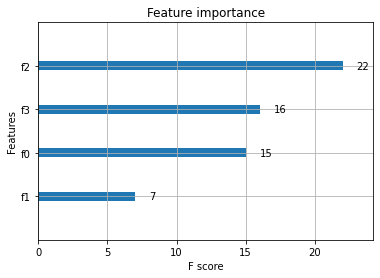

In [186]:
xgb.plot_importance(bst_with_evallist_and_early_stopping_50)

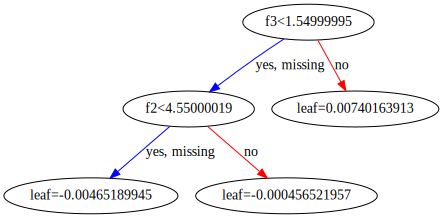

In [193]:
xgb.to_graphviz(bst_with_evallist, num_trees=2)

采用交叉验证得到最佳的n_estimators

In [194]:
cv_result = xgb.cv(param, dtrain ,num_boost_round=1000, nfold =5,
             metrics='logloss', early_stopping_rounds=5)
print(cv_result)

#最佳参数n_estimators
n_estimators = cv_result.shape[0]
print("Best n_estimators:", n_estimators)

   train-logloss-mean  train-logloss-std  test-logloss-mean  test-logloss-std
0          -12.515436           0.347071         -11.177138          1.048568
1          -12.525394           0.345119         -11.807876          0.944758
2          -12.525909           0.344746         -11.819958          0.960060
3          -12.525987           0.344652         -11.830949          0.975298
Best n_estimators: 4


### 基于Scikit-learn接口的分类

In [281]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
clf = xgb.XGBClassifier(
    n_estimators=20,  # 迭代次数
    learning_rate=0.1,  # 步长
    max_depth=5,  # 树的最大深度
    min_child_weight=1,  # 决定最小叶子节点样本权重和
    silent=1,  # 输出运行信息
    subsample=0.8,  # 每个决策树所用的子样本占总样本的比例（作用于样本）
    colsample_bytree=0.8,  # 建立树时对特征随机采样的比例（作用于特征）典型值：0.5-1
    objective='multi:softmax',  # 多分类！！！！！！
    num_class=3,
    nthread=4,
    seed=27)
clf.fit(X_train, y_train, verbose=True, eval_set=[(X_train,y_train),(X_test,y_test)], early_stopping_rounds=10)
fit_pred = clf.predict(X_test)
print(fit_pred [:5])
y_score = clf.predict_proba(X_test)
print(y_score[:5])
print(f'accuracy_score: {accuracy_score(y_test, fit_pred)}')
print(f"precision_score: {precision_score(y_test, fit_pred,average='macro')}")
print(f" recall_score: {recall_score(y_test, fit_pred,average='macro')}")
print(f"f1_score: {f1_score(y_test, fit_pred, average='macro')}")

[0]	validation_0-merror:0.05	validation_1-merror:0.02
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.05	validation_1-merror:0.02
[2]	validation_0-merror:0.03	validation_1-merror:0.02
[3]	validation_0-merror:0.03	validation_1-merror:0.02
[4]	validation_0-merror:0.03	validation_1-merror:0.02
[5]	validation_0-merror:0.02	validation_1-merror:0.02
[6]	validation_0-merror:0.03	validation_1-merror:0.02
[7]	validation_0-merror:0.02	validation_1-merror:0.02
[8]	validation_0-merror:0.03	validation_1-merror:0.02
[9]	validation_0-merror:0.02	validation_1-merror:0.02
[10]	validation_0-merror:0.03	validation_1-merror:0.02
Stopping. Best iteration:
[0]	validation_0-merror:0.05	validation_1-merror:0.02

[1 0 2 1 1]
[[0.3093285  0.3810263  0.30964527]
 [0.38103032 0.30976045 0.3092093 ]
 [0.31008574 0.31169128 0.378223  ]
 [0.3093285  0.3810263  0.30964527]
 [0.3

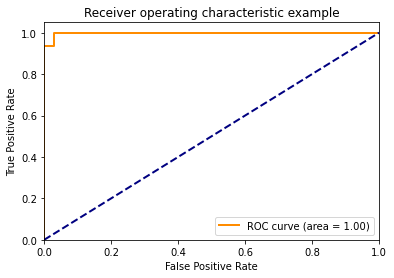

In [305]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_auc_score


# Binarize the output
y_test_onehot = label_binarize(y_test, classes=[0, 1, 2])
n_classes = np.unique(y_test)



# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in n_classes:
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_onehot.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(dpi=300,figsize=(15,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

### 基于Xgboost原生接口的回归

26.2157114817311


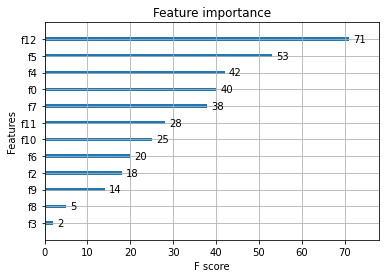

In [233]:
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
 
# 加载数据集,此数据集时做回归的
boston = load_boston()
X,y = boston.data,boston.target
 
# Xgboost训练过程
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
 
# 算法参数
params = {
    'booster':'gbtree',
    'objective':'reg:gamma',
    'gamma':0.1,
    'max_depth':5,
    'lambda':3,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'min_child_weight':3,
    'slient':1,
    'eta':0.1,
    'seed':1000,
    'nthread':4,
}
 
dtrain = xgb.DMatrix(X_train,y_train)
num_rounds = 300
plst = params.items()
model = xgb.train(plst,dtrain,num_rounds)
 
# 对测试集进行预测
dtest = xgb.DMatrix(X_test)
ans = model.predict(dtest)
print(mean_squared_error(y_test,ans))
 
# 显示重要特征
plot_importance(model)
plt.show()

### 基于Scikit-learn接口的回归

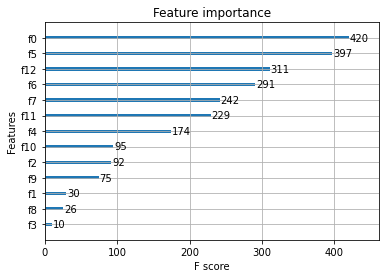

In [229]:
import xgboost as xgb
from xgboost import plot_importance
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston
 
# 导入数据集
boston = load_boston()
X ,y = boston.data,boston.target
 
# Xgboost训练过程
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
 
model = xgb.XGBRegressor(max_depth=5,learning_rate=0.1,n_estimators=160,silent=True,objective='reg:gamma')
model.fit(X_train,y_train)
 
# 对测试集进行预测
ans = model.predict(X_test)
 
# 显示重要特征
plot_importance(model)
plt.show()

## Stacking
本章讨论的最后一个集成方法叫做 Stacking（stacked generalization 的缩写）。这个算法基于一个简单的想法：不使用琐碎的函数（如硬投票）来聚合集合中所有分类器的预测，我们为什么不训练一个模型来执行这个聚合？图 7-12 展示了这样一个在新的回归实例上预测的集成。底部三个分类器每一个都有不同的值（3.1，2.7 和 2.9），然后最后一个分类器（叫做 blender 或者 meta learner ）把这三个分类器的结果当做输入然后做出最终决策（3.0）。